In [34]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from functools import partial
import pyproj
from shapely.ops import transform

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [49]:
def gen_points_inside_polygon(polygon, miles=0.25):
    '''Takes a polygon and number of miles as input, creates a square grid around the polygon edges
    and iterates in default quarter mile steps exhaustively across the grid, returns list of all the points
    generated'''
    
    #convert miles to degrees latitude/longitude 
    lat_increment = miles * 0.0145
    lon_increment = miles * 0.02 #this is specifically for L.A. (varies based on lat)
    
    #get the four corners of a grid of max and min lat/long values 
    min_long, min_lat, max_long, max_lat = polygon.bounds
    
    #iterate over the grid one unit at a time, append lats and lons to lists:
    longs, lats = [], []
    
    #Latitudes: start one half unit away from min_lat:
    lat = min_lat + (lat_increment / 2)
    while lat < max_lat:
        lats.append(lat)
        lat += lat_increment
    lats.append(max_lat)
    
    #repeat for longitude; conversion is diff, 1 mile = 0.0145 degrees
    #start one half unit above the min_lat
    lon = min_long + (lon_increment / 2)
    while lon < max_long:
        longs.append(lon)
        #increase .02 degrees (longitude conversion for Los Angeles)
        lon += lon_increment
    longs.append(max_long)

    #iterate thru all latitude and longitude points, instantiate shapely Point objects
    #and append them to a list:
    points = []
    for i in range(len(longs)):
        for j in range(len(lats)):
            points.append(Point(longs[i], lats[j]))
            
    #iterate over the points and throw out ones outside the polygon:
    points_inside_polygon = []
    for i in range(len(points)):
        if polygon.contains(points[i]):
            points_inside_polygon.append(points[i])
            
    #if there are no points inside the polygon (very small polygon), add center as a point:    
    if len(points_inside_polygon) == 0:
        points_inside_polygon.append(polygon.centroid)
            
    #return the list of Shapely points which are bound inside the polygon        
    return points_inside_polygon

def make_circle(lon, lat, miles=1):
    km = miles * 1.60934
    proj_wgs84 = pyproj.Proj(init='epsg:4326')
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buff = Point(0, 0).buffer(km * 1000)
    return Polygon(transform(project, buff).exterior.coords[:])

def get_num_groceries_in_circle(df, circle):
    min_long, min_lat, max_long, max_lat = circle.bounds
    df = df[(df.LATITUDE >= min_lat)&(df.LATITUDE <= max_lat)&(df.LONGITUDE>=min_long)&(df.LONGITUDE<=max_long)]
    num_groceries = 0
    for i in range(len(df)):
        if circle.contains(df.iloc[i]['LOCATION']):
            num_groceries += 1
    return num_groceries
        
def search_for_deserts(zip_df, markets_df):
    #initialize master dict which will store dicts for each zip code:
    return_dict = {}
    
    #iterate over each row in zip code dataframe:
    for i in range(len(zip_df)):
        zip_code = zip_df.iloc[i].zip_code
        nearby_grocery_counts = []
        desert_list = []
        
        #iterate over all the test_points for each zip code:
        for point in zip_df.iloc[i].test_points:
            lon, lat = point.x, point.y
            #make the circle around the test_point:
            circle = make_circle(lon, lat)
            #get the num of groceries within the circle and add to list for that zip code:
            num_nearby = get_num_groceries_in_circle(markets_df, circle)
            nearby_grocery_counts.append(num_nearby)
            #if there are no nearby groceries, add that point to list of food deserts:
            if num_nearby == 0:
                desert_list.append(point)
        
        #record the num of food deserts found for each zip code        
        num_food_deserts = len(desert_list)
        
        #store all the zip_code data as dict and add to master dict:
        
        #some zip codes are broken into mulitple polygons: this makes sure the data for these zip codes are aggregated:
        if zip_code in return_dict:
            return_dict[zip_code]['nearby_grocery_counts'] += nearby_grocery_counts
            return_dict[zip_code]['desert_list'] += desert_list
            return_dict[zip_code]['num_food_deserts'] += num_food_deserts
        else:
            return_dict[zip_code] = {'nearby_grocery_counts': nearby_grocery_counts, 
                               'desert_list': desert_list, 'num_food_deserts': num_food_deserts}
        
    #finished all iteration, now return the master dict of dictionaries for each zip code:
    return return_dict


def unpack_desert_search(desert_search_results):
    #initialize dict w/ empty lists
    unpacked = {'zip_code': [], 'nearby_grocery_counts': [], 'desert_list': [], 'num_food_deserts': []}
    #first get the zip code:
    for k, v in desert_search_results.items():
        unpacked['zip_code'].append(k)
        #now get the other key, value pairs for that zip code:
        for key, val in v.items():
            unpacked[key].append(val)
    #convert the dict into pandas df:        
    unpacked_df = pd.DataFrame(unpacked)        
    
    #initialize empty list of deserts:
    desert_list = []
    #iterate over the dataframe desert_list column and extract each desert and append to list:
    for i in range(len(unpacked_df)):
        deserts = unpacked_df.iloc[i].desert_list
        if len(deserts) > 0:
            for desert in deserts:
                desert_list.append(desert)
    
    #drop the desert_list column from the df:
    unpacked_df = unpacked_df.drop(columns=['desert_list'])
    
    #iterate over the grocery number counts and convert it to avg nearby groceries for each zip code:
    def get_avg(num_list):
        return round(sum(num_list)/len(num_list),1)
    
    unpacked_df.nearby_grocery_counts = unpacked_df.nearby_grocery_counts.apply(get_avg)
    unpacked_df = unpacked_df.rename(columns={'nearby_grocery_counts': 'avg_num_nearby_groceries'})
    
    #return the zip_code dataframe, and the list of all food deserts found in grid search:
    return unpacked_df, desert_list

In [50]:
#load the new markets data
df = pd.read_csv('CA.csv').drop(columns=['Unnamed: 10'])
markets = df[df.County == 'LOS ANGELES ']
#same filter as prev markets data:
exclude_string = "bakery|smoke|fizz|news|ginseng|wealth|mochi|beauty|perfume|big lots|97 CENT|marshal|water|BOYS AND GIRLS CLUB|vitamin|beer|honeybaked|sporting|ross|cnn|office|carwash|airport|service station|LUIQUOR|almonds|farm|snack|sweet|cork|baby|muscle|yogurt|godiva|stub|diy|baskin|ice cream|liq|home depot|wine|spirit|eleven|car wash|staples|am pm|99 cent|best buy|forever 21|craft|7-11|duty|sugar|mobil|gift shop|rite aid|76|petrol|weight watchers|7 eleven|golden state|dollar tree|six flags|arco|dress for less|liquor|walgreens|edible|fuel|studios|jenny craig|macy's|candies|general nutrition center|wateria|shell|oil|7-eleven|99 cents|valero|chevron|24 HOUR FITNESS|98 CENTS|candy|party|am/pm|circle k|gnc|automotive|gas|cvs|pharmacy|daiso"
markets = markets[~markets['STORE_NAME'].str.contains(exclude_string, flags=re.IGNORECASE, regex=True) == True].reset_index(drop=True)
markets = markets.rename(columns={'ZIP5':'zip_code', 'longitude':'LONGITUDE', 'latitude':'LATITUDE'})

#set dummy location column, then iterate and fill w/ Shapely Points:
markets['LOCATION'] = 'one'

for i in range(len(markets)):
    lat = markets.at[i, 'LATITUDE']
    lon = markets.at[i, 'LONGITUDE']
    markets.at[i, 'LOCATION'] = Point(lon, lat)
    
# Load the zip code polygon files
polygon_file = 'CAMS_ZIPCODE_STREET_SPECIFIC.shp'
polygons = gpd.read_file(polygon_file)
polygons = polygons.to_crs(epsg=4326)

#new df w/ only the columns we need:
zip_df = polygons[['Zip_Num', 'geometry']].rename(columns={'Zip_Num':'zip_code'})

#call the function and make a new column in our zip_df that holds a lit of points inside the polygon
zip_df['test_points'] = zip_df.geometry.apply(gen_points_inside_polygon)

#create new column that displays the num of points inside the polygon
zip_df['num_points'] = zip_df['test_points'].apply(len)

In [51]:
zip_df.head()

,zip_code,geometry,test_points,num_points
0,90001,POLYGON ((-118.2562720327559 33.98921307224975...,"[POINT (-118.2626835779772 33.96134746947096),...",50
1,90004,POLYGON ((-118.2904153141149 34.08336856317362...,"[POINT (-118.3360740655758 34.0703586312489), ...",44
2,90006,POLYGON ((-118.2843683929007 34.05603885709694...,"[POINT (-118.3079893523277 34.04110730996436),...",31
3,90007,POLYGON ((-118.2924807961456 34.04013885183708...,"[POINT (-118.2983632097604 34.02089473438523),...",38
4,90008,POLYGON ((-118.3673661121153 34.01806773141392...,"[POINT (-118.3754383527987 33.99870204843774),...",57


In [61]:
zip_df.num_points.sum()

57752

In [68]:
#execute the food desert grid search and unpack the results into df and list of deserts
full_search = search_for_deserts(zip_df, markets)
zip_code_groceries_df, all_deserts = unpack_desert_search(full_search)

In [73]:
#use the results to plot the deserts and grocery density by zip code:

#new df w/ only the columns we need:
polygons_df = zip_df[['zip_code', 'geometry']]

#convert list of desert points from grid search into df:
geo = {'geometry': all_deserts}
deserts_gdf = gpd.GeoDataFrame(geo)

# merge zip_deserts and polygons
grocery_density_df = polygons_df.merge(zip_code_groceries_df, left_on='zip_code', right_on='zip_code', how='outer')

(33.6, 35)

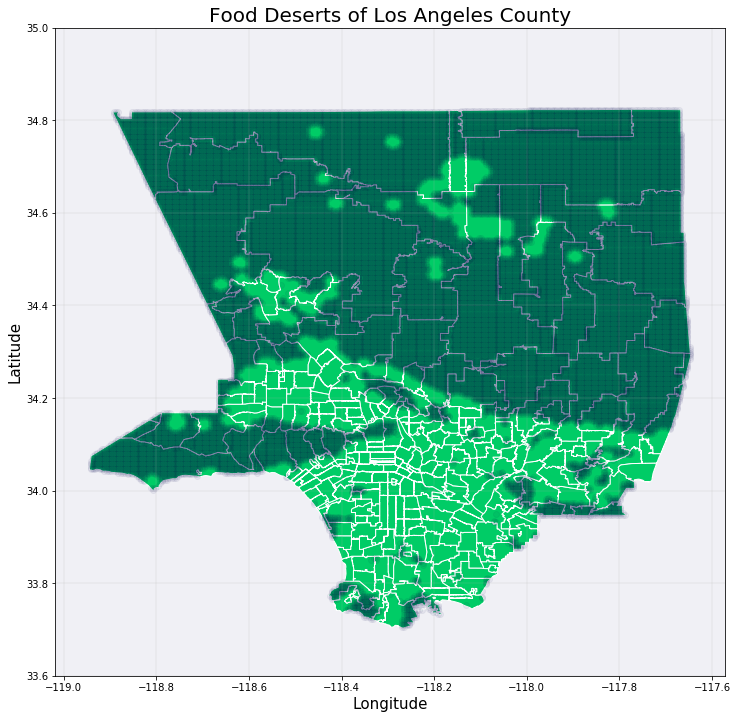

In [75]:
# Plot the zip code polygons, and then overlay the food desert points:
ax = polygons_df.plot(figsize=(12, 12), color='#00cc66', edgecolor='white')
deserts_gdf.plot(color='#00004d', alpha=0.05, ax=ax)
ax.set_facecolor('#f0f0f5')
plt.grid(linewidth=0.2)
plt.title('Food Deserts of Los Angeles County', fontsize=20)
#plt.figtext(.5,.9,'Food Deserts of Los Angeles County', fontsize=20, ha='center')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
ax.set_ylim([33.6,35])

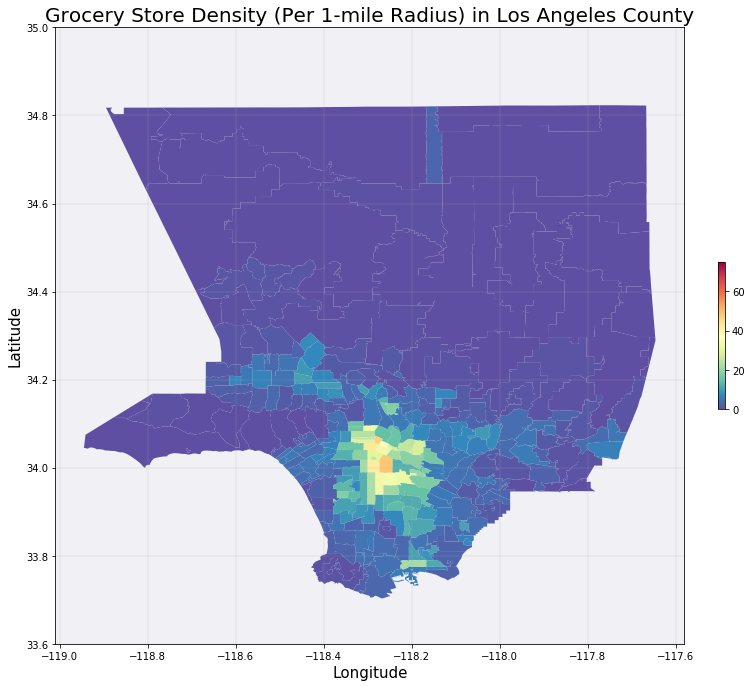

In [78]:
fig, ax = plt.subplots(figsize = (12,12))
cmap = 'Spectral_r'
#Color bar is created below
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=75))
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=.011)

ax.set_facecolor('#f0f0f5')
plt.title('Grocery Store Density (Per 1-mile Radius) in Los Angeles County',fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.grid(linewidth=0.2)
ax.set_ylim([33.6,35])
ax_zip = grocery_density_df.plot(column='avg_num_nearby_groceries', ax=ax, cmap=cmap, vmin=0, vmax =110)

In [84]:
income = pd.read_csv('income_clean.csv').drop(columns=['Community']).rename(columns={'Zip Code': 'zip_code'})
income_grocery_density = income.merge(grocery_density_df, on='zip_code', how='outer')
income_grocery_density['income_binned'] = pd.qcut(income_grocery_density['Estimated Median Income'], 10)

In [102]:
income_grocery_density.head()

,zip_code,Estimated Median Income,geometry,avg_num_nearby_groceries,num_food_deserts,grocery_percentile,income_percentile
0,90001,35660.0,POLYGON ((-118.2562720327559 33.98921307224975...,49.6,0.0,98.044693,5.027933
1,90002,34000.0,POLYGON ((-118.2345716372256 33.96100461711821...,30.8,0.0,89.106145,4.189944
2,90003,34397.0,POLYGON ((-118.2739251799847 33.98973095014135...,48.7,0.0,97.765363,4.748603
3,90004,46581.0,POLYGON ((-118.2904153141149 34.08336856317362...,35.2,0.0,90.782123,20.391061
4,90005,32461.0,POLYGON ((-118.3365046105697 34.06189191844368...,43.3,0.0,96.089385,3.072626


[Text(0, 0.5, 'Median Household Income Range'),
 Text(0.5, 0, 'AVG number of groceies within a 1-mile radius')]

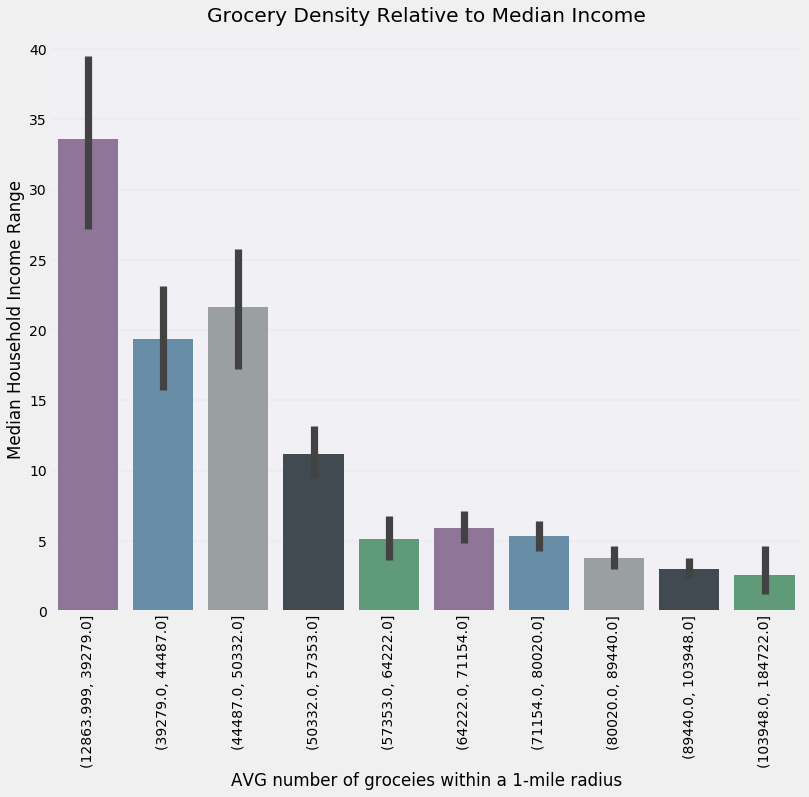

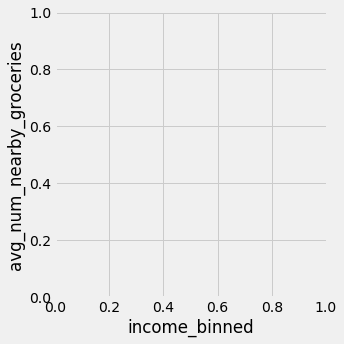

In [125]:
import seaborn as sns
plt.style.use('fivethirtyeight')
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#34495e", "#2ecc71"]
fig, ax = plt.subplots(figsize=(12,10))
ax.set_facecolor('#f0f0f5')
plt.xticks(rotation=90)
plt.grid(linewidth=0.2)
plt.title('Grocery Density Relative to Median Income')
#plt.xlabel('AVG number of groceies within a 1-mile radius')
sns.catplot('income_binned', 'avg_num_nearby_groceries', data=income_grocery_density, kind='bar', palette=sns.color_palette(flatui, desat=.5), ax=ax)
ax.set(xlabel='AVG number of groceies within a 1-mile radius', ylabel='Median Household Income Range')